# Histopathologic Cancer Detection using CNN Project

In this project we need to create an algorithm to identify metastatic cancer in small image patches taken from larger digital pathology scans.
CNN (Convolutional Neural Network) is used for image recognition and classification because they can lean spatial hierarchies of features from the training data. The train data we have here contains 220,025 images and the test set contains 57458 images.

In [1]:
import numpy as np 
import pandas as pd 
import os
from glob import glob
import cv2 # to read images and transform them
from PIL import Image
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf 
from tensorflow import keras
from keras.models import Sequential
from keras.layers import AvgPool2D,BatchNormalization, Conv2D, Dense, Flatten, Input, GlobalAveragePooling2D, Dropout 
from keras.layers import MaxPool2D, MaxPooling2D, ReLU, concatenate
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from sklearn import datasets,metrics
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.metrics import AUC
from tensorflow.keras.applications import DenseNet121

2024-04-23 22:31:10.185738: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-23 22:31:10.185842: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-23 22:31:10.192878: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
data_df = pd.read_csv('/kaggle/input/histopathologic-cancer-detection/train_labels.csv')
data_df.describe()

,label
count,220025.000000
mean,0.405031
std,0.490899
min,0.000000
25%,0.000000
50%,0.000000
75%,1.000000
max,1.000000


In [3]:
data_df['label']=data_df['label'].astype(str)
data_df.head()

,id,label
0,f38a6374c348f90b587e046aac6079959adf3835,0
1,c18f2d887b7ae4f6742ee445113fa1aef383ed77,1
2,755db6279dae599ebb4d39a9123cce439965282d,0
3,bc3f0c64fb968ff4a8bd33af6971ecae77c75e08,0
4,068aba587a4950175d04c680d38943fd488d6a9d,0


In [4]:
data_df['id']=data_df.apply(lambda row:(row['id']+".tif"),axis=1)
data_df.head()

,id,label
0,f38a6374c348f90b587e046aac6079959adf3835.tif,0
1,c18f2d887b7ae4f6742ee445113fa1aef383ed77.tif,1
2,755db6279dae599ebb4d39a9123cce439965282d.tif,0
3,bc3f0c64fb968ff4a8bd33af6971ecae77c75e08.tif,0
4,068aba587a4950175d04c680d38943fd488d6a9d.tif,0


(array([130908.,      0.,      0.,      0.,      0.,      0.,      0.,
             0.,      0.,  89117.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 10 artists>)

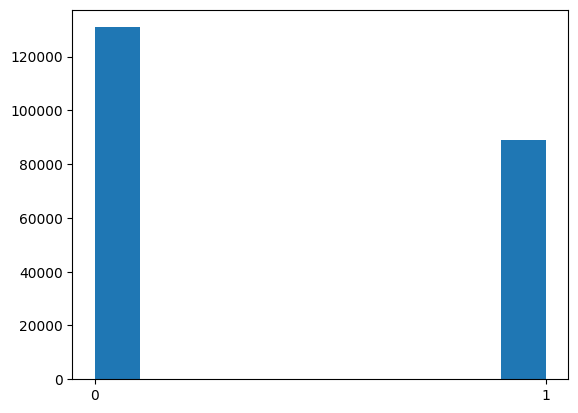

In [5]:
# Histogram for the labels
plt.hist(data_df["label"])

# Visualizing Images

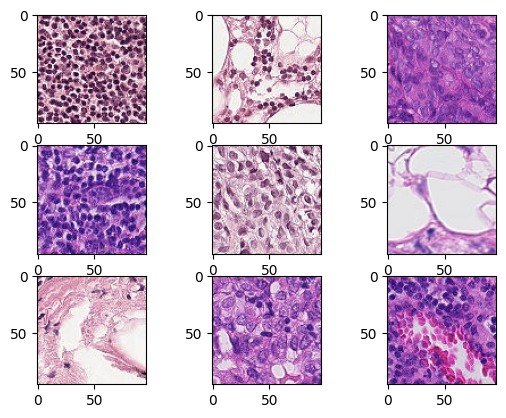

In [6]:
fig, axs = plt.subplots(3,3) 
h = 0
v = 0
for i in range(9):
    imid = data_df.id.sample(1).values[0]
    #print(imid)
    image = Image.open('/kaggle/input/histopathologic-cancer-detection/train/'+imid)
    axs[h,v].imshow(image)
    axs[h,v].imshow(image)
    if h == 2:
        v +=1
        h = 0
    else:
        h +=1

# Data Preprocessing
Since the dataset has 220,025 images, we will sample 50 percent of the data for training and validation sets.

In [7]:
data_subset = data_df.sample(frac=0.5,random_state=42)

In [8]:
# Split data into training and validation sets
train_df,val_df = train_test_split(data_subset,test_size=0.2,random_state=42)

In [9]:
print(train_df['id'].head())

60508     e2ca057475f48d208f39abe88d466c74ce3ddc7a.tif
90040     659da060ef0509489f1d4225f1c624ec486f43e1.tif
169027    caaeded79fa49aeb7ae7a85364315e926fb1d810.tif
19721     62b758fbbfbdb7ed6dca84cd3550a49b55ea930f.tif
184744    8a25035ba5dd9f33148768d11a504a915527739b.tif
Name: id, dtype: object


We use ImageDataGenerator for data augmentation and preprocessing for image dataset. We can scale pixel values within range [0,1] and use batches of dataset.

In [10]:
# path to dataset directory
batch_size = 128
image_size = (96,96)

datagen = ImageDataGenerator(
    rescale = 1./255, # Normalize pixel values to [0,1]
)

train_generator = datagen.flow_from_dataframe(
    dataframe=train_df,
    directory='/kaggle/input/histopathologic-cancer-detection/train',
    x_col='id',
    y_col='label',
    target_size = image_size,
    batch_size = batch_size,
    class_mode = 'binary',
    shuffle=True,
    seed = 42
)
validation_generator = datagen.flow_from_dataframe(
    dataframe=val_df,
    directory='/kaggle/input/histopathologic-cancer-detection/train',
    x_col='id',
    y_col='label',
    target_size = image_size,
    batch_size = batch_size,
    class_mode = 'binary',
    shuffle=True,
    seed = 42
)

# Check the class indices
print("Class indices",train_generator.class_indices)
print("Class indices",validation_generator.class_indices)

Found 88009 validated image filenames belonging to 2 classes.
Found 22003 validated image filenames belonging to 2 classes.
Class indices {'0': 0, '1': 1}
Class indices {'0': 0, '1': 1}


We use sequential model which is high-level API from Tensorflow Keras as it is simple, easy to use and efficient.

In [11]:
model = Sequential([
    Conv2D(32,(3,3),activation='relu',input_shape=(96,96,3)),
    MaxPooling2D((2,2)),
    Conv2D(64,(3,3),activation='relu'),
    MaxPooling2D((2,2)),
    Conv2D(128,(3,3),activation='relu'),
    MaxPooling2D((2,2)),
    Flatten(),
    Dense(128,activation='relu'),
    Dropout(0.5),
    Dense(1,activation='sigmoid')
])

/opt/conda/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


In [12]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 94, 94, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 47, 47, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 45, 45, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 22, 22, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 20, 20, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 10, 10, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 12800)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     1,638,528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,731,905 (6.61 MB)

 Trainable params: 1,731,905 (6.61 MB)

 Non-trainable params: 0 (0.00 B)

In [13]:
# Model Compilation
model.compile(optimizer='adam',
             loss='binary_crossentropy',
             metrics=["AUC"])

In [14]:
# Train the model
from tensorflow.keras.callbacks import EarlyStopping
# Define early stopping callback
early_stopping = EarlyStopping(monitor='val_loss',patience=3,restore_best_weights=True)
# Training the model with early stopping
history = model.fit(train_generator,
                   steps_per_epoch=len(train_generator)//batch_size,
                   epochs=10,
                   validation_data=validation_generator,
                   validation_steps = len(validation_generator)//batch_size,
                   callbacks=[early_stopping])

Epoch 1/10


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


5/5 ━━━━━━━━━━━━━━━━━━━━ 12s 2s/step - AUC: 0.4927 - loss: 0.7853 - val_AUC: 0.6062 - val_loss: 0.6950
Epoch 2/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 6s 1s/step - AUC: 0.5526 - loss: 0.6866 - val_AUC: 0.6838 - val_loss: 0.6730
Epoch 3/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 7s 1s/step - AUC: 0.5472 - loss: 0.6630 - val_AUC: 0.7434 - val_loss: 0.6746
Epoch 4/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 6s 1s/step - AUC: 0.6349 - loss: 0.6494 - val_AUC: 0.7640 - val_loss: 0.6420
Epoch 5/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 6s 1s/step - AUC: 0.7499 - loss: 0.6381 - val_AUC: 0.7952 - val_loss: 0.6308
Epoch 6/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 6s 1s/step - AUC: 0.6965 - loss: 0.6350 - val_AUC: 0.8074 - val_loss: 0.6199
Epoch 7/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 6s 1s/step - AUC: 0.7723 - loss: 0.5788 - val_AUC: 0.8077 - val_loss: 0.5943
Epoch 8/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 7s 1s/step - AUC: 0.7967 - loss: 0.5471 - val_AUC: 0.7623 - val_loss: 0.6020
Epoch 9/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 6s 1s/step - AUC: 0.7781 - loss: 0.5613 - val_AUC: 0.7992 - val_loss: 

In [15]:
# list all data in history
print(history.history.keys())

dict_keys(['AUC', 'loss', 'val_AUC', 'val_loss'])


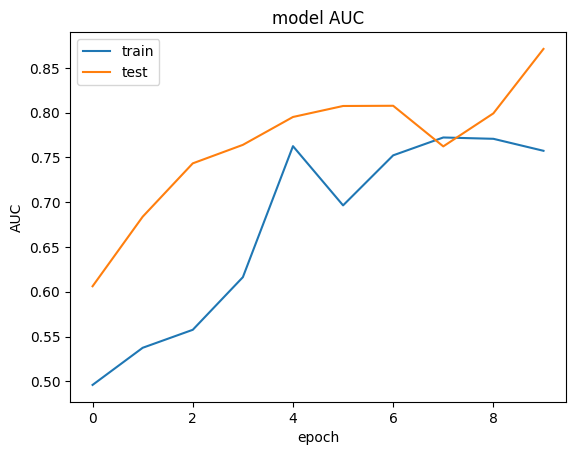

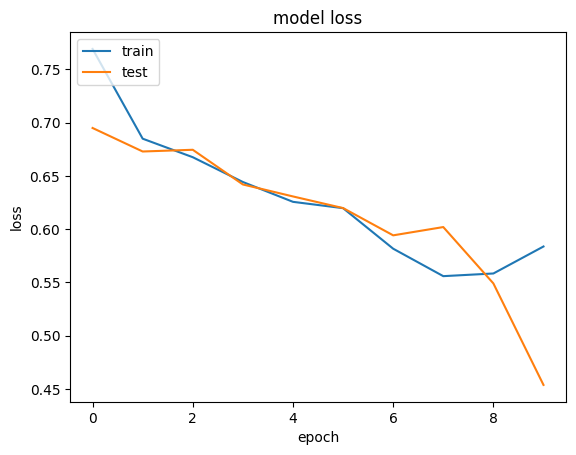

In [16]:
# summarize history for AUC
plt.plot(history.history['AUC'])
plt.plot(history.history['val_AUC'])
plt.title('model AUC')
plt.ylabel('AUC')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# Prediction on test data for submission

In [17]:
# Create test dataset
test_image_dir = '/kaggle/input/histopathologic-cancer-detection/test'
test_image_file_names = os.listdir(test_image_dir)
test_df = pd.DataFrame({'id':[os.path.join(test_image_dir,filename)for filename in test_image_file_names]})
test_df.head()

,id
0,/kaggle/input/histopathologic-cancer-detection...
1,/kaggle/input/histopathologic-cancer-detection...
2,/kaggle/input/histopathologic-cancer-detection...
3,/kaggle/input/histopathologic-cancer-detection...
4,/kaggle/input/histopathologic-cancer-detection...


In [18]:
# Evaluate the model on the test set
test_generator = datagen.flow_from_dataframe(
    dataframe=test_df,
    directory='/kaggle/input/histopathologic-cancer-detection/test',
    x_col='id',
    target_size = image_size,
    batch_size = batch_size,
    class_mode = None,
    shuffle=False,
    seed = 42
)

Found 57458 validated image filenames.


In [19]:
# Process test images using the generator
test_features = model.predict(test_generator,steps=len(test_generator))

/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


449/449 ━━━━━━━━━━━━━━━━━━━━ 216s 479ms/step


In [20]:
test_features

array([[0.31309202],
       [0.05003341],
       [0.4362481 ],
       ...,
       [0.7167264 ],
       [0.12625948],
       [0.18457846]], dtype=float32)

In [21]:
threshold = 0.5
pred = np.where(test_features>threshold,1,0)
print(pred)

[[0]
 [0]
 [0]
 ...
 [1]
 [0]
 [0]]


In [22]:
test_df["label"]=pred
test_df.head()

,id,label
0,/kaggle/input/histopathologic-cancer-detection...,0
1,/kaggle/input/histopathologic-cancer-detection...,0
2,/kaggle/input/histopathologic-cancer-detection...,0
3,/kaggle/input/histopathologic-cancer-detection...,1
4,/kaggle/input/histopathologic-cancer-detection...,0


In [23]:
test_df.shape

(57458, 2)

In [24]:
test_df['id']=test_df['id'].str.replace(".tif",'')
test_df['id']=test_df['id'].str.replace("/kaggle/input/histopathologic-cancer-detection/test/",'')

In [25]:
test_df.to_csv("predictions.csv",index=False,header=['id','label'])

# Model2
Using Adagrad optimizer, binary_crossentropy loss and accuracy metrics.

In [26]:
model2 = Sequential([
    Conv2D(32,(3,3),activation='relu',input_shape=(96,96,3)),
    MaxPooling2D((2,2)),
    Conv2D(64,(3,3),activation='relu'),
    MaxPooling2D((2,2)),
    Conv2D(128,(3,3),activation='relu'),
    MaxPooling2D((2,2)),
    Flatten(),
    Dense(128,activation='relu'),
    Dropout(0.5),
    Dense(1,activation='sigmoid')
])

/opt/conda/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


In [27]:
model2.compile(optimizer='Adagrad',
             loss='binary_crossentropy',
             metrics=["accuracy"])

In [28]:
# Train the model
from tensorflow.keras.callbacks import EarlyStopping
# Define early stopping callback
early_stopping = EarlyStopping(monitor='val_loss',patience=3,restore_best_weights=True)
# Training the model with early stopping
history = model2.fit(train_generator,
                   steps_per_epoch=len(train_generator)//batch_size,
                   epochs=10,
                   validation_data=validation_generator,
                   validation_steps = len(validation_generator)//batch_size,
                   callbacks=[early_stopping])

Epoch 1/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 12s 2s/step - accuracy: 0.6306 - loss: 0.6758 - val_accuracy: 0.6328 - val_loss: 0.6668
Epoch 2/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 6s 1s/step - accuracy: 0.5990 - loss: 0.6709 - val_accuracy: 0.6641 - val_loss: 0.6561
Epoch 3/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 6s 1s/step - accuracy: 0.5718 - loss: 0.6890 - val_accuracy: 0.5312 - val_loss: 0.6933
Epoch 4/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 6s 1s/step - accuracy: 0.5601 - loss: 0.6912 - val_accuracy: 0.5703 - val_loss: 0.6806
Epoch 5/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 6s 1s/step - accuracy: 0.5718 - loss: 0.6850 - val_accuracy: 0.6094 - val_loss: 0.6701


In [29]:
# list all data in history
print(history.history.keys())

dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])


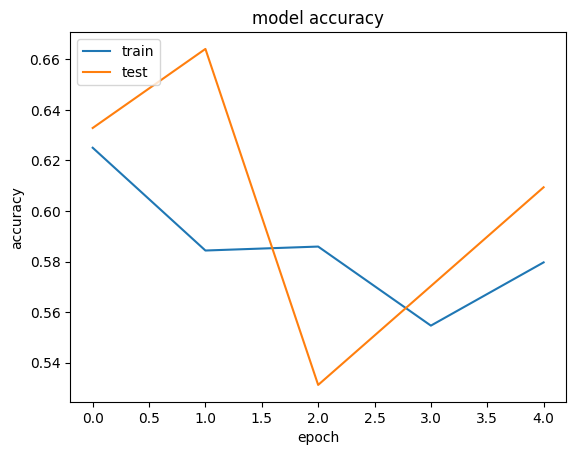

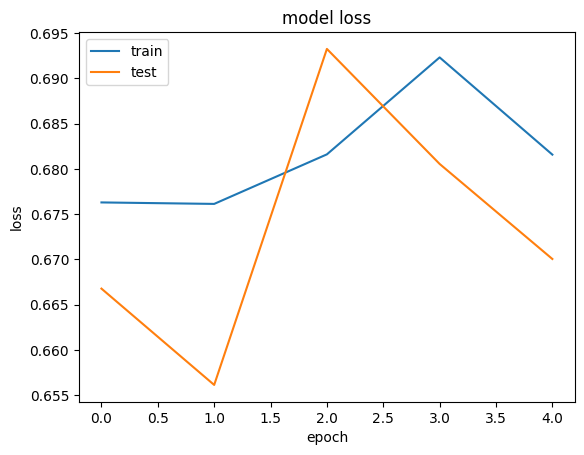

In [30]:
# summarize history for Accuracy

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# Model3
Using adam optimizer, binarycrossentropy loss and accuracy metrics.

In [36]:
model3 = Sequential([
    Conv2D(32,(3,3),activation='relu',input_shape=(96,96,3)),
    MaxPooling2D((2,2)),
    Conv2D(64,(3,3),activation='relu'),
    MaxPooling2D((2,2)),
    Conv2D(128,(3,3),activation='relu'),
    MaxPooling2D((2,2)),
    Flatten(),
    Dense(128,activation='relu'),
    Dropout(0.5),
    Dense(1,activation='sigmoid')
])

In [37]:
model3.compile(optimizer='adam',
             loss='binary_crossentropy',
             metrics=["accuracy"])

In [38]:
# Train the model
from tensorflow.keras.callbacks import EarlyStopping
# Define early stopping callback
early_stopping = EarlyStopping(monitor='val_loss',patience=3,restore_best_weights=True)
# Training the model with early stopping
history = model3.fit(train_generator,
                   steps_per_epoch=len(train_generator)//batch_size,
                   epochs=10,
                   validation_data=validation_generator,
                   validation_steps = len(validation_generator)//batch_size,
                   callbacks=[early_stopping])

Epoch 1/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 13s 2s/step - accuracy: 0.4881 - loss: 0.7633 - val_accuracy: 0.6172 - val_loss: 0.6684
Epoch 2/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 7s 1s/step - accuracy: 0.5987 - loss: 0.6671 - val_accuracy: 0.5547 - val_loss: 0.6552
Epoch 3/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 6s 1s/step - accuracy: 0.5906 - loss: 0.6543 - val_accuracy: 0.6797 - val_loss: 0.5798
Epoch 4/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 7s 1s/step - accuracy: 0.7443 - loss: 0.5685 - val_accuracy: 0.7500 - val_loss: 0.5291
Epoch 5/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 6s 1s/step - accuracy: 0.6832 - loss: 0.5863 - val_accuracy: 0.6875 - val_loss: 0.5915
Epoch 6/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 6s 1s/step - accuracy: 0.7321 - loss: 0.5865 - val_accuracy: 0.6797 - val_loss: 0.5860
Epoch 7/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 6s 1s/step - accuracy: 0.7123 - loss: 0.5654 - val_accuracy: 0.6641 - val_loss: 0.6038


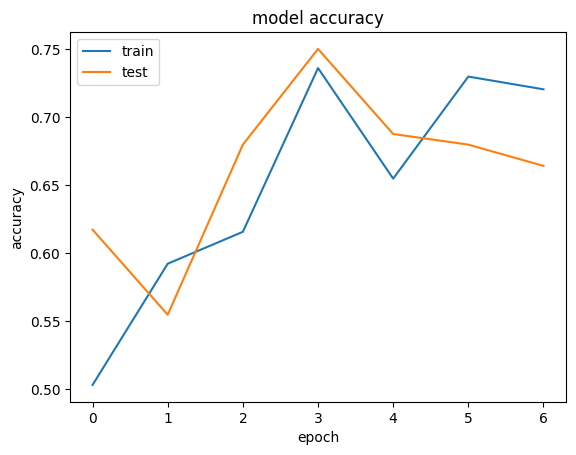

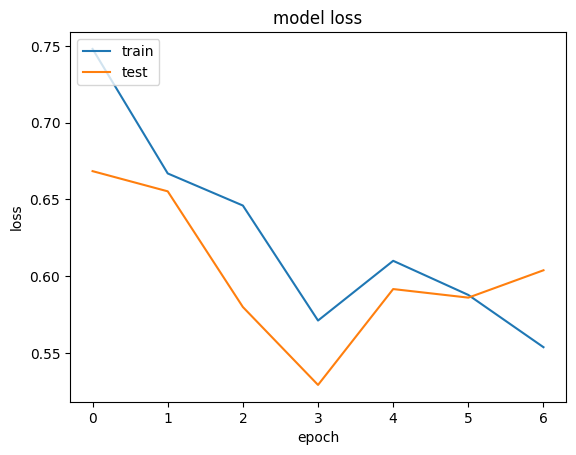

In [39]:
# summarize history for Accuracy

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

Thus, we see that:
* For adam optimizer the accuracy increases  as the number of epochs increases. 
* For adam optimizer loss decreases as the number of epochs increases.
* For Adagrad optimizer the accuracy decreases as the number of epochs increases.
* For Adagrad optimizer loss increases as the number of epochs increases.
* For adam optimizer the AUC increases  as the number of epochs increases. 
* For adam optimizer val_AUC=0.8712.
